In [7]:
import zipfile
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as transforms
import torch.nn as nn
import numpy as np
import data
import scipy.signal
import librosa


path = './data/'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = 'MelLoss'

In [8]:
class PreProcessor(torch.nn.Module):
    def __init__(
        self,
        input_samplerate = 16000,
        resample_samplerate = 16000,
        n_fft = 480,
        power=None
    ):
        super().__init__()
        self.output_size = (n_fft+2)//2
        self.window = torch.hann_window(window_length=n_fft)
        self.resample = transforms.Resample(input_samplerate, resample_samplerate)
        self.transform = transforms.Spectrogram(n_fft=n_fft, power=power, window_fn=torch.hann_window, normalized=True, center=True)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        resampled = self.resample(waveform)
        spec = self.transform(resampled)
        spec = spec.permute(0, 2, 1)
        return spec


class PostProcessor(torch.nn.Module):
    def __init__(
        self,
        output_samplerate = 16000,
        resample_samplerate = 16000,
        n_fft = 480
    ):
        super().__init__()
        n_fft = n_fft
        self.window = torch.hann_window(window_length=n_fft)
        self.resample = transforms.Resample(resample_samplerate, output_samplerate)
        self.transform = transforms.InverseSpectrogram(n_fft=n_fft, window_fn=torch.hann_window, normalized=True, center=True)

    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        spec = spec.permute(0, 2, 1)
        waveform = self.transform(spec)
        resampled = self.resample(waveform)
        return resampled

In [9]:
class MelLoss(torch.nn.Module):
    def __init__(
        self,
        sample_rate,
        n_stft=101,
        n_mels=10,
        device='cpu'
    ):
        super().__init__()
        self.melscale_transform = torchaudio.functional.melscale_fbanks(
            n_stft,
            f_min = 0,
            f_max = sample_rate / 2.0,
            n_mels = n_mels,
            sample_rate = sample_rate,
            norm = 'slaney',
        ).to(device)

    def __str__(self):
        return "MelLoss"
        
    def forward(self, estimated_spec, reference_spec):        
        mel_error_spec = torch.matmul(            
            (estimated_spec - reference_spec).abs()**2,
            self.melscale_transform
        )
        return mel_error_spec.clamp(min=1e-6).log().mean(dim=-2).mean()


class CombinedSpectralLoss(torch.nn.Module):
    def __init__(self, alpha = 0.5):
        super().__init__()
        self.mse_loss = nn.L1Loss()
        self.alpha = alpha
    
    def forward(self, est_spec, clean_spec):
        est_spec_real = est_spec.real
        est_spec_imag = est_spec.imag
        
        clean_spec_real = clean_spec.real
        clean_spec_imag = clean_spec.imag
        
        l_mag = self.mse_loss(est_spec.abs(), clean_spec.abs())
        print(l_mag)
        l_ri = self.mse_loss(est_spec_real, clean_spec_real) + self.mse_loss(est_spec_imag, clean_spec_imag) 
        print(l_ri)
        loss = self.alpha * l_mag + (1 - self.alpha) * l_ri
        return loss.clamp(min=1e-6).mean()

In [10]:
import time
import torch

def train(dataloader, dataset, model, preprocessor, loss_fn, optimizer, scheduler, epochs=1):
    size = len(dataset)
    model.train()
    start_time = time.perf_counter()

    for epoch in range(epochs):
        flag = False

        for batch, (noisy_batch, clean_batch, sr) in enumerate(dataloader):
            noisy_spec = preprocessor(noisy_batch).to(device)
            clean_spec = preprocessor(clean_batch).to(device)

            batch_size = noisy_batch.shape[0]

            est_clean_spec = model(noisy_spec)

            loss = loss_fn(est_clean_spec, clean_spec)
            scheduler.step(loss)

            if torch.isnan(loss) or torch.isinf(loss) or loss > 1e9:
                print(f"Encountered NaN loss at batch {batch}, skipping this batch.")
                flag = True
                break

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            if (batch+1) % 10 == 0:
                curr_time = time.perf_counter()
                loss, current = loss.item(), 1 + (batch)*batch_size + epoch*size
                print(f"loss: {loss:>7f}  [{current:>5d}/{size*epochs:>5d}] at {curr_time-start_time:>5f} sec")
                start_time = curr_time
        if flag:
            break

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_decoder=False, is_last=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=(1, 1)) if is_decoder else\
                nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(num_features=out_channels),
            nn.PReLU() if not is_last else nn.Identity()
        )

    def forward(self, x):
        out = self.conv(x)
        return out
    
    
class UNet(nn.Module):
    def __init__(
        self,
        n_fft=101,
        device='cpu',
    ): 
        super().__init__()
        self.eps = 1e-9
        self.device = device
        self.spec_size = n_fft // 2 + 1 
        
        self.en_conv1 = CNNBlock(1, 16)
        self.en_conv2 = CNNBlock(16, 32)
        self.en_conv3 = CNNBlock(32, 64)
        self.en_conv4 = CNNBlock(64, 128)

        self.bottleneck = CNNBlock(128, 128)

        self.de_conv1 = CNNBlock(128 + 128, 64, is_decoder=True)
        self.de_conv2 = CNNBlock(64 + 64, 32, is_decoder=True)
        self.de_conv3 = CNNBlock(32 + 32, 16, is_decoder=True)
        self.de_conv4 = CNNBlock(16 + 16, 3, is_decoder=True, is_last=True)

        self.dim_reduce = nn.Linear(self.spec_size * 2, self.spec_size)

    def eval(self):
        self.eval_state = True
        return
    
    def train(self):
        self.eval_state = False
        return

    def forward(self, input_spec: torch.Tensor):
        x_real = input_spec.real
        x_imag = input_spec.imag

        x = torch.cat((x_real, x_imag), dim=-1)
        x = x.unsqueeze(1)
        
        # Encoding
        en_out1 = self.en_conv1(x)
        en_out2 = self.en_conv2(en_out1)
        en_out3 = self.en_conv3(en_out2)
        en_out4 = self.en_conv4(en_out3)

        # LSTM
        btn_out = self.bottleneck(en_out4)

        # Decoding
        de_out1 = self.de_conv1(torch.cat((btn_out, en_out4), dim=1))
        print(de_out1.shape)
        de_out2 = self.de_conv2(torch.cat((de_out1, en_out3), dim=1))
        de_out3 = self.de_conv3(torch.cat((de_out2, en_out2), dim=1))
        de_out4 = self.de_conv4(torch.cat((de_out3, en_out1), dim=1))
        masks = self.dim_reduce(de_out4.permute(1, 0, 2, 3))
        
        # Complex spectrogram reconstruction
        x_magnitude = input_spec.abs()
        x_phase = input_spec.angle()

        mag_mask = torch.sigmoid(masks[0, :].squeeze(0))
        magnitude = mag_mask * x_magnitude

        real_phase_mask = torch.tanh(masks[1, :].squeeze(0))
        imag_phase_mask = torch.tanh(masks[2, :].squeeze(0))

        real_phase_mask = real_phase_mask / torch.sqrt(real_phase_mask ** 2 + imag_phase_mask ** 2 + self.eps)
        imag_phase_mask = imag_phase_mask / torch.sqrt(real_phase_mask ** 2 + imag_phase_mask ** 2 + self.eps)

        real_part = magnitude * (real_phase_mask * torch.cos(x_phase) - imag_phase_mask * torch.sin(x_phase))
        imag_part = magnitude * (real_phase_mask * torch.sin(x_phase) + imag_phase_mask * torch.cos(x_phase))

        out = torch.complex(real_part, imag_part)
        return out

In [12]:
batch_size = 16
n_epoch = 50
lr = 5e-3
n_fft = 200
n_mels = 40

dataset = data.NoisySpeech(path, device=device)
_, _, input_samplerate = dataset.__getitem__(0)
resample_samplerate = 16000

enhancer = UNet(n_fft=n_fft)
enhancer.to(device)

optimizer = torch.optim.Adam(params=enhancer.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, threshold=0.08, min_lr=5e-6)
# loss = MelLoss(sample_rate=resample_samplerate, n_stft=n_fft // 2 + 1, n_mels=n_mels, device=device)
loss = CombinedSpectralLoss(alpha=0.8)
preprocessor = PreProcessor(input_samplerate=input_samplerate, n_fft=n_fft, power=None)

train_size = int(0.15 * len(dataset))
eval_size = int(0.10 * len(dataset))
leftover = len(dataset) - train_size - eval_size

train_dataset, eval_dataset, _ = torch.utils.data.random_split(dataset, [train_size, eval_size, leftover])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data.collate_fn)

# train(
#     dataloader=train_dataloader,
#     dataset=train_dataset,
#     model=enhancer,
#     preprocessor=preprocessor,
#     loss_fn=loss,
#     optimizer=optimizer,
#     epochs=n_epoch,
#     scheduler=scheduler,
# )

In [13]:
eval_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data.collate_fn)
noisy_batch, clean_batch, sr = next(iter(eval_loader))
noisy_spec = preprocessor(noisy_batch).to(device)
clean_spec = preprocessor(clean_batch).to(device)

postprocessor = PostProcessor(output_samplerate=input_samplerate, n_fft=n_fft)

enhancer.eval()
with torch.no_grad():
    enhanced_spec = enhancer(noisy_spec)

enhanced_batch = postprocessor(enhanced_spec.to('cpu'))
clean_audio = postprocessor(clean_spec.to('cpu'))
noisy_audio = postprocessor(noisy_spec.to('cpu'))

KeyboardInterrupt: 

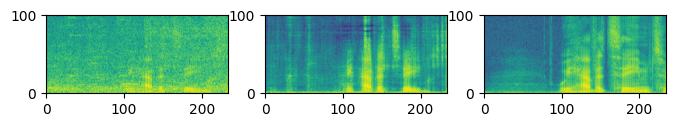

In [38]:
idx = np.random.randint(10)
plt.figure(figsize=(8,3))
plt.subplot(131)
plt.imshow(noisy_spec[idx,:,:].to('cpu').abs().log().mT.numpy(),origin='lower')
plt.subplot(132)
plt.imshow(enhanced_spec[idx,:,:].to('cpu').abs().log().mT.detach().numpy(),origin='lower')
plt.subplot(133)
plt.imshow(clean_spec[idx,:,:].to('cpu').abs().log().mT.numpy(),origin='lower')
plt.show()

import IPython
IPython.display.display(IPython.display.Audio(noisy_batch[idx,:].detach().numpy(),rate=int(sr)))
IPython.display.display(IPython.display.Audio(enhanced_batch[idx,:].detach().numpy(),rate=int(sr)))
IPython.display.display(IPython.display.Audio(clean_batch[idx,:],rate=int(sr)))

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last=False):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(num_features=out_channels),
        ]
        if not is_last:
            layers.append(nn.PReLU())
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        return out
    
    
class CRN(nn.Module):
    def __init__(
        self,
        n_fft=101,
        n_gru_layers=1,
        device='cpu'
    ): 
        super().__init__()
        self.eps = 1e-9
        self.device = device
        self.spec_size = n_fft // 2 + 1    
        
        self.en_conv1 = CNNBlock(1, 2)
        self.en_conv2 = CNNBlock(2, 4)
        self.en_conv3 = CNNBlock(4, 8)
        self.en_conv4 = CNNBlock(8, 16)
        
        self.gru = nn.GRU(16 * self.spec_size * 2, 16 * self.spec_size * 2, num_layers=n_gru_layers, bidirectional=True)
        self.lin_compress = nn.Linear(16 * self.spec_size * 2 * 2, 16 * self.spec_size * 2)
        self.lnorm = nn.LayerNorm(16 * self.spec_size * 2)
        self.act = nn.PReLU()

        self.de_conv1 = CNNBlock(16 + 16, 8)
        self.de_conv2 = CNNBlock(8 + 8, 4)
        self.de_conv3 = CNNBlock(4 + 4, 2)
        self.de_conv4 = CNNBlock(2 + 2, 3, is_last=True)

        self.dim_reduce = nn.Linear(self.spec_size * 2, self.spec_size)

    def eval(self):
        self.eval_state = True
        return
    
    def train(self):
        self.eval_state = False
        return

    def forward(self, input_spec: torch.Tensor):
        x_real = input_spec.real
        x_imag = input_spec.imag

        x = torch.cat((x_real, x_imag), dim=-1)
        x = x.unsqueeze(1)

        # Encoding
        en_out1 = self.en_conv1(x)
        en_out2 = self.en_conv2(en_out1)
        en_out3 = self.en_conv3(en_out2)
        en_out4 = self.en_conv4(en_out3)

        # LSTM
        out = en_out4.permute(0, 2, 3, 1) 
        out = out.contiguous().view(out.size(0), out.size(1), -1)
        gru_out, _ = self.gru(out)
        gru_out = self.act(self.lnorm(self.lin_compress(gru_out)))
        gru_out = gru_out.permute(0, 2, 1).contiguous().view(*en_out4.shape)

        # Decoding
        de_out1 = self.de_conv1(torch.cat((gru_out, en_out4), dim=1))
        de_out2 = self.de_conv2(torch.cat((de_out1, en_out3), dim=1))
        de_out3 = self.de_conv3(torch.cat((de_out2, en_out2), dim=1))
        de_out4 = self.de_conv4(torch.cat((de_out3, en_out1), dim=1))
        masks = self.dim_reduce(de_out4.permute(1, 0, 2, 3))
        
        # Complex spectrogram reconstruction
        x_magnitude = input_spec.abs()
        x_phase = input_spec.angle()

        mag_mask = torch.sigmoid(masks[0, :].squeeze(0))
        magnitude = mag_mask * x_magnitude

        real_phase_mask = torch.tanh(masks[1, :].squeeze(0))
        imag_phase_mask = torch.tanh(masks[2, :].squeeze(0))

        real_phase_mask = real_phase_mask / torch.sqrt(real_phase_mask ** 2 + imag_phase_mask ** 2 + self.eps)
        imag_phase_mask = imag_phase_mask / torch.sqrt(real_phase_mask ** 2 + imag_phase_mask ** 2 + self.eps)

        real_part = magnitude * (real_phase_mask * torch.cos(x_phase) - imag_phase_mask * torch.sin(x_phase))
        imag_part = magnitude * (real_phase_mask * torch.sin(x_phase) + imag_phase_mask * torch.cos(x_phase))

        out = torch.complex(real_part, imag_part)
        return out

In [46]:
# eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size, shuffle=True, collate_fn=data.collate_fn)
noisy_batch, clean_batch, sr = next(iter(eval_loader))
noisy_spec = preprocessor(noisy_batch).to(device)
clean_spec = preprocessor(clean_batch).to(device)

postprocessor = PostProcessor(output_samplerate=input_samplerate, n_fft=n_fft)

enhancer1 = torch.load("./experiments/models/crn-model-test.pt")
enhancer2 = torch.load("./experiments/models/gru-unet-model.pt")

enhancer1.eval()
with torch.no_grad():
    enhanced_spec1 = enhancer1(noisy_spec)

enhancer2.eval()
with torch.no_grad():
    enhanced_spec2 = enhancer2(noisy_spec)

C:\Users\Hung Nguyen\AppData\Local\Temp\ipykernel_17168\4253363854.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enhancer1 = torch.load("./experiments/models/crn-model

torch.Size([16, 64, 322, 202])


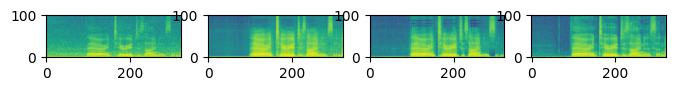

In [52]:
enhanced_batch1 = postprocessor(enhanced_spec1.to('cpu'))
enhanced_batch2 = postprocessor(enhanced_spec2.to('cpu'))

clean_audio = postprocessor(clean_spec.to('cpu'))
noisy_audio = postprocessor(noisy_spec.to('cpu'))

idx = np.random.randint(16)
plt.figure(figsize=(8,3))

plt.subplot(141)
plt.imshow(noisy_spec[idx,:,:].to('cpu').abs().log().mT.numpy(),origin='lower')

plt.subplot(142)
plt.imshow(enhanced_spec1[idx,:,:].to('cpu').abs().log().mT.detach().numpy(),origin='lower')

plt.subplot(143)
plt.imshow(enhanced_spec2[idx,:,:].to('cpu').abs().log().mT.detach().numpy(),origin='lower')

plt.subplot(144)
plt.imshow(clean_spec[idx,:,:].to('cpu').abs().log().mT.numpy(),origin='lower')

plt.show()

import IPython
IPython.display.display(IPython.display.Audio(noisy_batch[idx,:].detach().numpy(),rate=int(sr)))
IPython.display.display(IPython.display.Audio(enhanced_batch1[idx,:].detach().numpy(),rate=int(sr)))
IPython.display.display(IPython.display.Audio(enhanced_batch2[idx,:].detach().numpy(),rate=int(sr)))
IPython.display.display(IPython.display.Audio(clean_batch[idx,:],rate=int(sr)))

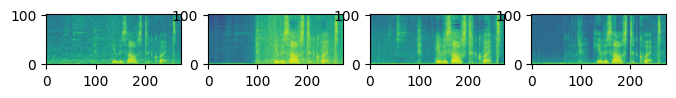

In [111]:
enhanced_batch1 = postprocessor(enhanced_spec1.to('cpu'))
enhanced_batch2 = postprocessor(enhanced_spec2.to('cpu'))

clean_audio = postprocessor(clean_spec.to('cpu'))
noisy_audio = postprocessor(noisy_spec.to('cpu'))

idx = np.random.randint(16)
plt.figure(figsize=(8,3))

plt.subplot(141)
plt.imshow(noisy_spec[idx,:,:].to('cpu').abs().log().mT.numpy(),origin='lower')

plt.subplot(142)
plt.imshow(enhanced_spec1[idx,:,:].to('cpu').abs().log().mT.detach().numpy(),origin='lower')

plt.subplot(143)
plt.imshow(enhanced_spec2[idx,:,:].to('cpu').abs().log().mT.detach().numpy(),origin='lower')

plt.subplot(144)
plt.imshow(clean_spec[idx,:,:].to('cpu').abs().log().mT.numpy(),origin='lower')

plt.show()

import IPython
IPython.display.display(IPython.display.Audio(noisy_batch[idx,:].detach().numpy(),rate=int(sr)))
IPython.display.display(IPython.display.Audio(enhanced_batch1[idx,:].detach().numpy(),rate=int(sr)))
IPython.display.display(IPython.display.Audio(enhanced_batch2[idx,:].detach().numpy(),rate=int(sr)))
IPython.display.display(IPython.display.Audio(clean_batch[idx,:],rate=int(sr)))